# import stuff and define functions

In [1]:
# true if working from tbi, false is working from home
tbi = False

if tbi:
    base_folder = '/scr/aldea/kgutenbrunner/github/MA/'
else:
    base_folder = '/Users/katringutenbrunner/Desktop/MA/github/MA/'

## importing

In [2]:
import os
import csv
import re

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns

from Bio import AlignIO, SeqIO
import varnaapi
import logomaker

import RNA

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


## functions

In [3]:
# remove gaps from target structure to get structure based on sequence
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

# get target frequency, based on target structure
def target_frequency(sequence, structure):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(structure)

# get length of sequence
def get_length(seq):
    return len(seq.replace('-', ''))

# check if the positions in the sequnces is a possible base pair
possible_pairs = [('A', 'U'), ('C', 'G'), ('G', 'C'), ('G', 'U'), ('U', 'A'), ('U', 'G')]
def check_bp(seq, position):
    if (seq[position[0]], seq[position[1]]) in possible_pairs:
        return True
    else:
        return False

In [4]:
# get mfe and mfe structure from sequence
def get_mfe(sequence):
    fc = RNA.fold_compound(sequence)
    fc.pf()
    (ss, mfe) = fc.mfe()
    return ss, mfe

# remove gaps from sequence and get mfe and mfe structure
def get_mfe_w_gaps(sequence):
    fc = RNA.fold_compound(sequence.replace('-', ''))
    fc.pf()
    (ss, mfe) = fc.mfe()
    return add_gaps(sequence, ss)

# add gaps back into the structure from a sequence with gaps
def add_gaps(sequence, structure):
    structure = list(structure)
    new_ss = [structure.pop(0) if nt != '-' else '-' for  nt in sequence]
    return ''.join(new_ss)

# convert dotbracket ss into a matrix
def db_to_matrix(db):
    matrix = np.zeros((len(db), len(db)), dtype=int)
    db_dict = {')': '(',
               ']': '[',
               '}': '{',
               '>': '<',
               'a': 'A'}
    db_stacks = {'(':[],
               '[':[],
               '{':[],
               '<':[],
               'A': []
               }

    for i, symbol in enumerate(db):
        if symbol in db_stacks.keys():
            db_stacks[symbol].append(i)
        elif symbol in ')}]>a':
            opening_index = db_stacks[db_dict[symbol]].pop()
            closing_index = i
            matrix[opening_index][closing_index] = 1
            matrix[closing_index][opening_index] = 1
    if any(db_stacks.values()):
        print(db)
        print(db_stacks)
        raise ValueError(f"structure {db} not balanced ")
    return matrix

# get base pairing heatmap of a matrix of base pair probabilities
def bp_plot(bp_matrix, min_max = False,folder = False):
    fig, ax = plt.subplots()
    if min_max:
        cimg = ax.imshow(bp_matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    else:
        cimg = ax.imshow(bp_matrix, cmap='viridis', interpolation='nearest')
    ax.set_xticks(np.arange(0, bp_matrix.shape[1], 5), np.arange(0, bp_matrix.shape[1], 5))
    ax.set_yticks(np.arange(0, bp_matrix.shape[0], 5), np.arange(0, bp_matrix.shape[0], 5))
    ax.set_title('MFE probability')
    ax.grid(color='gray', linestyle='--', linewidth=0.4)
    cbar = plt.colorbar(cimg, ax=ax)

    cbar_ax = cbar.ax  # Access the color bar's axes
    max_value = np.max(bp_matrix)
    cbar_ax.axhline(y=max_value, color='red', linestyle='--')  # Add a horizontal line


    if folder:
        plt.savefig(folder)
        plt.clf()
    else:
        plt.show()
        plt.clf()

In [5]:
# function for correlation analysis
def correlation_analysis(df, method = 'spearman', statistic_file = False, save_fig = False, labels = None, mask = True):
    stats_df = df.drop(columns='name').astype(int)
    
    #create some correlation analysis
    corr =  stats_df.corr(method=method, numeric_only=False)
    
    # Display the correlation matrix
    if mask:
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan

    if statistic_file:
        corr.to_csv(statistic_file)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1,)
    plt.colorbar(label=f'Correlation',fraction=0.046, pad=0.04)
    #plt.colorbar(img, ax=ax)

    if labels:
        plt.xticks(np.arange(len(corr)), labels, rotation=45, fontsize=16)
        plt.yticks(np.arange(len(corr)), labels, fontsize=16)
    else:
        plt.xticks(np.arange(len(corr)), corr.columns, rotation=45, fontsize=12)
        plt.yticks(np.arange(len(corr)), corr.columns, fontsize=12)
    plt.tight_layout()    
    if save_fig:
        plt.savefig(save_fig)
    else:
        plt.show()
    return corr

In [6]:
def find_character(text, char):
    return [i for i, c in enumerate(text) if c == char]

def find_structure(ss):
    beta_indices = []
    gamma_indices = []       

    beta_stack = []
    gamma_stack = []

    beta = True
    for i in range(len(ss)):
        if ss[i] == '<':
            if beta:
                beta_stack.append(i)
                beta_indices.append(i)
            else:
                gamma_stack.append(i)
                gamma_indices.append(i)
        elif ss[i] == '>':
            if beta:
                beta_stack.pop()
                beta_indices.append(i)
            else:
                gamma_stack.pop()
                gamma_indices.append(i)
            if len(beta_stack) == 0:
                beta = False
    if beta_stack or gamma_stack:
        print('structure is wrong')
        raise ValueError


    alpha_indices = find_character(ss, '(') + find_character(ss, ')')

    return alpha_indices, beta_indices, gamma_indices

def get_length_of_structures(seq, ss):
    alpha_positions, beta_positions, gamma_positions = ss
    alpha_start, alpha_stop = alpha_positions[0], alpha_positions[-1] + 1
    beta_start, beta_stop = beta_positions[0], beta_positions[-1] + 1
    gamma_start, gamma_stop = gamma_positions[0], gamma_positions[-1] + 1


    alpha_stem = len([1 for pos in alpha_positions if seq[pos]!='-'])
    n = len(alpha_positions)
    hl_start, hl_stop = alpha_positions[int(n/2) -1] + 1, alpha_positions[int(n/2)]
    alpha = get_length(seq[alpha_start:hl_start]) + get_length(seq[hl_stop:alpha_stop])

    n = len(beta_positions)
    hl_start, hl_stop = beta_positions[int(n/2) -1] + 1, beta_positions[int(n/2)]
    beta = get_length(seq[beta_start:beta_stop])
    beta_hl = get_length(seq[hl_start:hl_stop])
    beta_stem = beta-beta_hl
    
    n = len(gamma_positions)
    hl_start, hl_stop = gamma_positions[int(n/2) -1] + 1, gamma_positions[int(n/2)]
    gamma = get_length(seq[gamma_start:gamma_stop])
    gamma_hl = get_length(seq[hl_start:hl_stop])
    gamma_stem = gamma-gamma_hl

    return alpha_stem, alpha, beta_stem, beta_hl, beta, gamma_stem, gamma_hl, gamma

In [7]:
def bp_between_regions(cons, ss):
    """Check if there are base pairs between two regions of consecutive dots in the predicted structure."""
    # Step 1: Identify the two regions of dots in `cons`
    regions = []
    start = None
    
    for i, char in enumerate(cons):
        if char == '.':
            if start is None:
                start = i  # Start of a dot region
        else:
            if start is not None:
                regions.append((start, i - 1))  # End of a dot region
                start = None
    
    if start is not None:
        regions.append((start, len(cons) - 1))  # Catch any trailing dot region
    
    if len(regions) < 2:
        return False
    
    first_region, second_region = regions[:2]

    # Step 2: Use a stack to find base pairs in the `ss` string and check if they connect the regions
    stack = []
    for i, char in enumerate(ss):
        if char == '(':
            stack.append(i)  # Push index onto stack for open parenthesis
        elif char == ')':
            if stack:
                j = stack.pop()  # Pop matching opening index
                # Check if one index is in the first region and the other in the second
                if (first_region[0] <= j <= first_region[1] and second_region[0] <= i <= second_region[1]) or \
                   (first_region[0] <= i <= first_region[1] and second_region[0] <= j <= second_region[1]):
                    return True  # Found a base pair connecting the two regions

    return False  # No connecting base pairs found

def count_bp_between_regions(cons, ss):
    # Step 1: Identify the two regions of dots in `cons`
    regions = []
    start = None
    
    for i, char in enumerate(cons):
        if char == '.':
            if start is None:
                start = i  # Start of a dot region
        else:
            if start is not None:
                regions.append((start, i - 1))  # End of a dot region
                start = None
    
    if start is not None:
        regions.append((start, len(cons) - 1))  # Catch any trailing dot region
    
    if len(regions) < 2:
        return False
    
    first_region, second_region = regions[:2]

    # Step 2: Use a stack to find base pairs in the `ss` string and count those connecting the regions
    stack = []
    bp_count = 0  # Initialize counter for base pairs between regions
    
    for i, char in enumerate(ss):
        if char == '(':
            stack.append(i)  # Push index onto stack for open parenthesis
        elif char == ')':
            if stack:
                j = stack.pop()  # Pop matching opening index
                # Check if one index is in the first region and the other in the second
                if (first_region[0] <= j <= first_region[1] and second_region[0] <= i <= second_region[1]) or \
                   (first_region[0] <= i <= first_region[1] and second_region[0] <= j <= second_region[1]):
                    bp_count += 1  # Increment counter

    return bp_count  # Return the total count of connecting base pairs




## colors for plots


In [8]:
TBFV_color = '#7a5195'
IR_color = '#bc5090'
CM_color = '#ffa600'

In [9]:
TBFV_color="#0072b2"
IR_color="#e69f00"
CM_color="#009e73"

# Tick Borne Flavi Virus Analysis

## import and clean up data

In [10]:
# get all the stk files except YFV
stk_folder = os.path.join(base_folder, 'data/tbfv_stk/')
skip = ['TYUV', 'XiFV', 'SREV']
# SREV and TYUV have no beta stem
# XiFV has very small stems
stk_files = [
    os.path.join(stk_folder, file)
    for file in os.listdir(stk_folder)
    if file.endswith('xrRNA1.stk') and not any(skip_item in file for skip_item in skip)
]

In [11]:
# get the seqeuences from each stk file
sequences = []
rfs = []
for stk_file in stk_files:
    align = AlignIO.read(stk_file, "stockholm")
    rfs.append(align.column_annotations['reference_annotation'])
    for record in align:
        sequences.append(str(record.seq))
TBFV_sequences = sequences

In [12]:
# import data from length counting file
# left YVf out since it has a really big hl beta --> outlier
TBFV_count_file = os.path.join(base_folder, 'xrRNA_design/analysis_TBFV/data/TBFV_ss.csv')
df = pd.read_csv(TBFV_count_file, skiprows=13, delimiter=",")

In [13]:
#only want xrRNA1
xrRNA1_df = df[df['xrRNA-no'] == 1]
#only want samples with both pseudoknots
df_nts = xrRNA1_df[xrRNA1_df['PKs?'] == '1+2']
df_nts = df_nts.drop(columns=['PKs?', 'xrRNA-no', 'numSeqs'])

#only want samples with all 3 stems
df_nts = df_nts[df_nts['mlA/G'] == "-"]
df_nts = df_nts.drop(columns=['mlA/G'])

#remove columns which have only 0s / -
col_no_values = df_nts.columns[(df_nts == "-").all()]
df_nts = df_nts.drop(columns=col_no_values)

#remove columns which have only 0s / -
same_value_columns = df_nts.columns[df_nts.nunique() == 1]
df_nts = df_nts.drop(columns=same_value_columns)

# change - to 0s
df_nts = df_nts.replace('-', 0)

# add up Interloop, (have some with 2 loops, add to one loop)
df_nts = df_nts.replace('2+2', 4)

temp_df = df_nts.drop(columns='name').astype(int)
#double the nucleotides in Stems because we counted basepairs not nucleotides
df_nts['stemA'] = temp_df['stemA'] * 2
df_nts['stemB'] = temp_df['stemB'] * 2
df_nts['stemG'] = temp_df['stemG'] * 2
# add stem structure together for further analysis
df_nts['alpha'] = temp_df['stemA'] * 2 + temp_df['ilA'] + temp_df['blA']
df_nts['beta'] = temp_df['stemB'] *2 + temp_df['hlB'] + temp_df['blB']
df_nts['gamma'] = temp_df['stemG'] *2 + temp_df['hlG']
df_nts['ibA'] =   temp_df['ilA'] # + temp_df['blA']
df_nts['ibB'] = temp_df['blB'] 
df_nts = df_nts.drop(columns=['ilA', 'blA', 'blB'])

# save the df as unique dataframe for later use
df_TBFV = df_nts
df_TBFV

,name,stemA,stemB,hlB,stemG,hlG,uPK1,PK1bPK2,len,alpha,beta,gamma,ibA,ibB
0,ALKV,22,8,4,10,10,8,0,84,26,12,20,4,0
1,DTV,24,6,9,8,11,12,2,90,24,15,19,0,0
3,GGV,24,6,7,14,4,15,2,88,24,14,18,0,1
5,KFDV,24,8,4,10,10,8,2,84,26,12,20,2,0
6,KSIV,28,8,3,8,12,8,2,86,30,11,20,2,0
8,LGTV,24,10,3,10,10,11,0,89,28,13,20,4,0
10,LIV,24,6,4,8,12,11,0,85,27,10,20,2,0
15,NEGV,26,6,4,8,12,11,0,85,27,10,20,0,0
17,OHFV,24,6,4,8,12,11,0,86,28,10,20,2,0
19,POWV,24,6,9,8,11,14,2,89,24,15,19,0,0


In [14]:
# import data from length counting file
# left YVf out since it has a really big hl beta --> outlier
TBFV_PK_file = os.path.join(base_folder, 'xrRNA_design/analysis_TBFV/data/pk_stats.txt')
df_PK = pd.read_csv(TBFV_PK_file, skiprows=1, delimiter=",")
df_PK = df_PK.drop(columns=['posA', 'posB', 'total'])
df_PK['n_PK2'] = df_PK['n_PK2']*2
df_PK['n_PK1'] = df_PK['n_PK1']*2
df_TBFV = df_TBFV.merge(df_PK, how='outer')
df_TBFV = df_TBFV.rename(columns={'uPK1':'bPK','until': "b_PK", 'after': "a_PK"})

In [15]:
new_order = ['name', 'stemA', 'ibA', 'alpha', 'stemB', 'hlB', 'ibB', 'beta', 'stemG','hlG','gamma',  'bPK', 'n_PK1','PK1bPK2', 'n_PK2','b_PK','a_PK', 'len']
df_TBFV = df_TBFV[new_order]
df_TBFV

,name,stemA,ibA,alpha,stemB,hlB,ibB,beta,stemG,hlG,gamma,bPK,n_PK1,PK1bPK2,n_PK2,b_PK,a_PK,len
0,ALKV,22,4,26,8,4,0,12,10,10,20,8,6,0,12,3,0,84
1,DTV,24,0,24,6,9,0,15,8,11,19,12,6,2,14,2,0,90
2,GGV,24,0,24,6,7,1,14,14,4,18,15,6,2,8,0,0,88
3,KFDV,24,2,26,8,4,0,12,10,10,20,8,6,2,10,4,2,84
4,KSIV,28,2,30,8,3,0,11,8,12,20,8,6,2,8,5,3,86
5,LGTV,24,4,28,10,3,0,13,10,10,20,11,6,0,10,4,0,89
6,LIV,24,2,27,6,4,0,10,8,12,20,11,6,0,10,5,1,85
7,NEGV,26,0,27,6,4,0,10,8,12,20,11,6,0,10,5,1,85
8,OHFV,24,2,28,6,4,0,10,8,12,20,11,6,0,10,5,1,86
9,POWV,24,0,24,6,9,0,15,8,11,19,14,6,2,8,4,3,89


## structure analysis

### boxplot of lengths

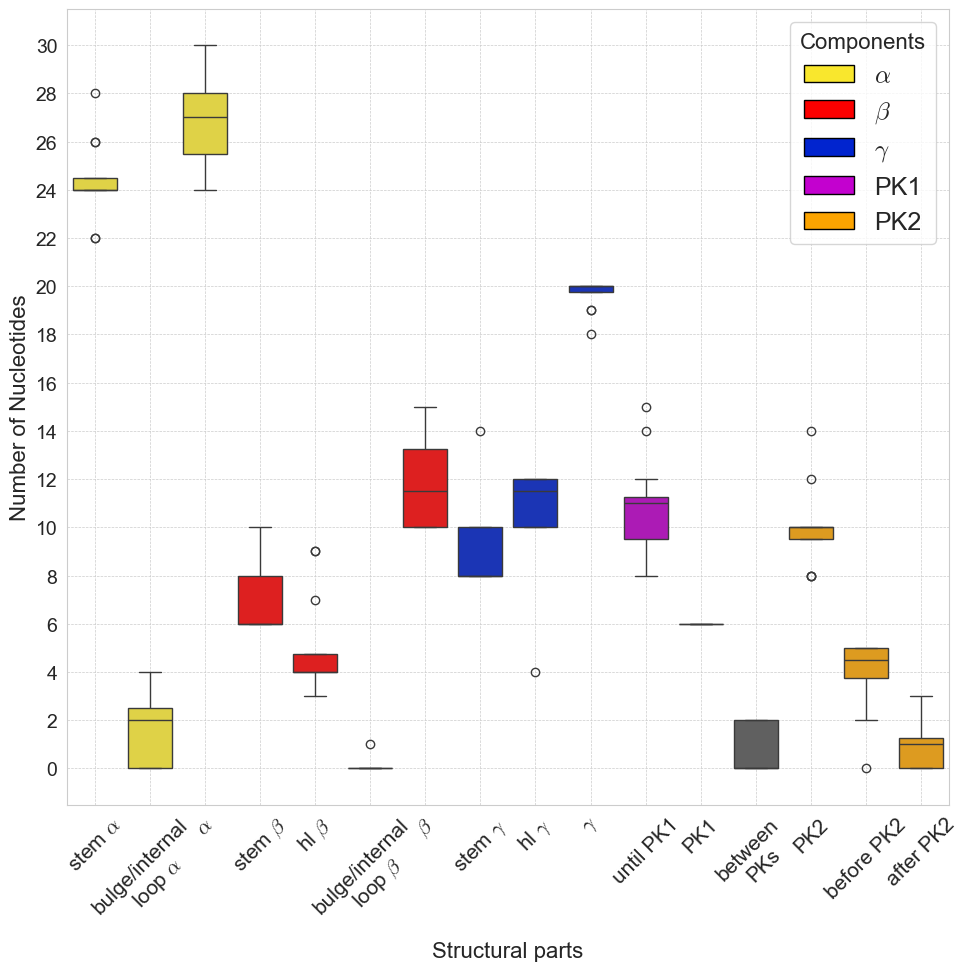

In [25]:
# create boxplot of different lengths
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern fonts for math text
plt.rcParams.update({'font.size': 16})

temp_df = df_TBFV.drop(columns=['name', 'len']).astype(int)
plt.figure(figsize=(10, 10))

sns.set_style("whitegrid") 

colors = ['#F9E72D', '#FC0000', '#0124CF', '#C301CF', '#FCA400']
color_map = [colors[0], colors[0], colors[0], colors[1], colors[1], colors[1], colors[1], colors[2], colors[2] ,colors[2], colors[3], colors[3], '#606060', colors[4], colors[4], colors[4]]

sns.boxplot(data=temp_df, palette=color_map)  # 
labels = [r'stem $\alpha$', 'bulge/internal\n' + r'loop $\alpha$', r'$\alpha$', 
          r'stem $\beta$', r'hl $\beta$', 'bulge/internal\n' + r'loop $\beta$', r'$\beta$', 
          r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'until PK1', 'PK1', 'between\nPKs', 'PK2', 
          'before PK2', 'after PK2']


plt.xticks(list(range(0, len(labels))), labels, rotation=45, fontsize=15)
plt.yticks(np.arange(0, 32, step=2), fontsize=14)

plt.xlabel('Structural parts', fontsize=16)
plt.ylabel('Number of Nucleotides', fontsize=16)

plt.grid(visible=True, which='major', axis='both', linestyle='--', linewidth=0.5)
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label=r'$\alpha$'),
    Patch(facecolor=colors[1], edgecolor='black', label=r'$\beta$'),
    Patch(facecolor=colors[2], edgecolor='black', label=r'$\gamma$'),
    Patch(facecolor=colors[3], edgecolor='black', label='PK1'),
    Patch(facecolor=colors[4], edgecolor='black', label='PK2')
]
plt.legend(handles=legend_elements, title="Components",  loc='upper right', fontsize=18) #bbox_to_anchor=(1.05, 1),

plt.tight_layout()
save_file = os.path.join(base_folder, 'thesis/images/TBFV_xrRNA_analysis_boxplot.png')
plt.savefig(save_file)


In [17]:
temp_df.describe()

,stemA,ibA,alpha,stemB,hlB,ibB,beta,stemG,hlG,gamma,bPK,n_PK1,PK1bPK2,n_PK2,b_PK,a_PK
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,12.000000
mean,24.333333,1.833333,26.666667,6.833333,4.916667,0.083333,11.833333,9.000000,10.666667,19.666667,10.833333,6.0,0.833333,10.000000,3.916667,1.083333
std,1.669694,1.585923,1.969464,1.337116,2.151462,0.288675,1.992410,1.809068,2.269695,0.651339,2.208798,0.0,1.029857,1.705606,1.564279,1.083625
min,22.000000,0.000000,24.000000,6.000000,3.000000,0.000000,10.000000,8.000000,4.000000,18.000000,8.000000,6.0,0.000000,8.000000,0.000000,0.000000
25%,24.000000,0.000000,25.500000,6.000000,4.000000,0.000000,10.000000,8.000000,10.000000,19.750000,9.500000,6.0,0.000000,9.500000,3.750000,0.000000
50%,24.000000,2.000000,27.000000,6.000000,4.000000,0.000000,11.500000,8.000000,11.500000,20.000000,11.000000,6.0,0.000000,10.000000,4.500000,1.000000
75%,24.500000,2.500000,28.000000,8.000000,4.750000,0.000000,13.250000,10.000000,12.000000,20.000000,11.250000,6.0,2.000000,10.000000,5.000000,1.250000
max,28.000000,4.000000,30.000000,10.000000,9.000000,1.000000,15.000000,14.000000,12.000000,20.000000,15.000000,6.0,2.000000,14.000000,5.000000,3.000000


In [18]:
# create boxplot of different lengths
plt.rcParams['text.usetex'] = True

temp_df = df_TBFV.drop(columns=['name', 'len']).astype(int)
plt.figure(figsize=(10, 10))

sns.set_style("whitegrid") 

colors = sns.color_palette('colorblind', 4)
color_map = [colors[0], colors[0], colors[0], colors[1], colors[1], colors[1], colors[1], colors[2], colors[2] ,colors[2], colors[3], colors[3], colors[3], colors[3], colors[3]]

sns.violinplot(data=temp_df, inner='box', palette=color_map)  # inner='box' adds boxplot elements inside violins

labels = [r'stem $\alpha$', 'bulge/internal\n' + r'loop $\alpha$', r'$\alpha$', 
          r'stem $\beta$', r'hl $\beta$', 'bulge/internal\n' + r'loop $\beta$', r'$\beta$', 
          r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'until PK1', 'PK2', 
          'between PKs', 'before PK2', 'after PK2']


plt.xticks(list(range(0, len(labels))), labels, rotation=45, fontsize=14)

plt.xlabel('Structural parts', fontsize=14)
plt.ylabel('Number of Nucleotides', fontsize=14)
''
plt.grid(visible=True, which='major', axis='both', linestyle='--', linewidth=0.5)
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label=r'$\alpha$'),
    Patch(facecolor=colors[1], edgecolor='black', label=r'$\beta$'),
    Patch(facecolor=colors[2], edgecolor='black', label=r'$\gamma$'),
    Patch(facecolor=colors[3], edgecolor='black', label='PK')
]
plt.legend(handles=legend_elements, title="Structures",  loc='upper right', fontsize=14) #bbox_to_anchor=(1.05, 1),

save_file = os.path.join(base_folder, 'thesis/images/TBFV_xrRNA_analysis_violinplot.png')
plt.savefig(save_file)


/var/folders/54/ry4wc1s953jdm1j76gdcpwpc0000gn/T/ipykernel_81284/3992272488.py:12: UserWarning: 
The palette list has fewer values (15) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(data=temp_df, inner='box', palette=color_map)  # inner='box' adds boxplot elements inside violins


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

Error in callback <function _draw_all_if_interactive at 0x15a7f5800> (for post_execute), with arguments args (),kwargs {}:


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

<Figure size 1000x1000 with 1 Axes>

### correlation analysis

In [53]:
df_TBFV

,name,stemA,ibA,alpha,stemB,hlB,ibB,beta,stemG,hlG,gamma,bPK,n_PK1,PK1bPK2,n_PK2,b_PK,a_PK,len
0,ALKV,22,4,26,8,4,0,12,10,10,20,8,6,0,12,3,0,84
1,DTV,24,0,24,6,9,0,15,8,11,19,12,6,2,14,2,0,90
2,GGV,24,0,24,6,7,1,14,14,4,18,15,6,2,8,0,0,88
3,KFDV,24,2,26,8,4,0,12,10,10,20,8,6,2,10,4,2,84
4,KSIV,28,2,30,8,3,0,11,8,12,20,8,6,2,8,5,3,86
5,LGTV,24,4,28,10,3,0,13,10,10,20,11,6,0,10,4,0,89
6,LIV,24,2,27,6,4,0,10,8,12,20,11,6,0,10,5,1,85
7,NEGV,26,0,27,6,4,0,10,8,12,20,11,6,0,10,5,1,85
8,OHFV,24,2,28,6,4,0,10,8,12,20,11,6,0,10,5,1,86
9,POWV,24,0,24,6,9,0,15,8,11,19,14,6,2,8,4,3,89


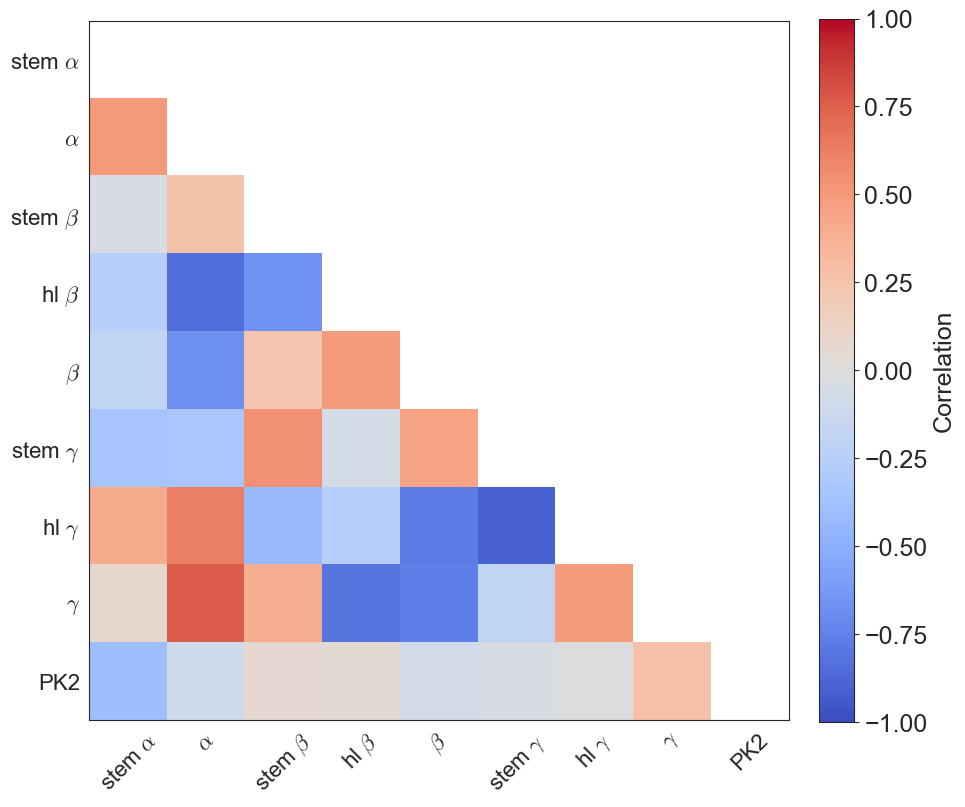

In [55]:
plt.rcParams.update({'font.size': 18})


temp_df = df_TBFV.drop(columns=['ibA', 'ibB',  'a_PK', 'b_PK', 'len', 'n_PK1', 'PK1bPK2', 'bPK'])
labels = [r'stem $\alpha$', r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2']
sns.set_style("white") 

save_file = os.path.join(base_folder, 'thesis/images/TBFV_xrRNA_analysis_correlation.png')
correlation_analysis(temp_df, method="spearman", labels=labels, mask = True, save_fig=save_file)
del temp_df

### length distribution

Min: 84
Max: 90
Mean: 86.42


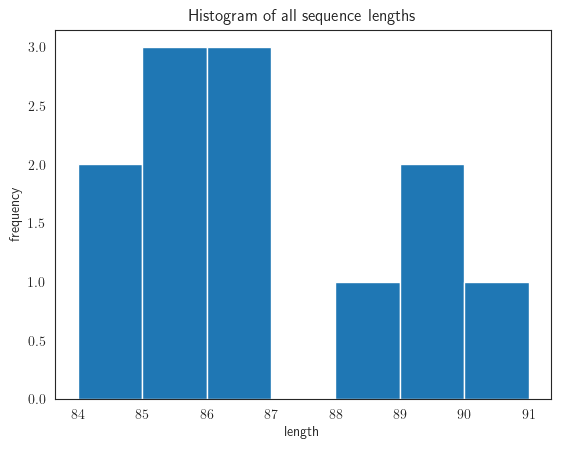

In [19]:
# plot the distributions of the lengths
sequence_lengths = [int(i) for i in list(df_TBFV['len'])]

# plot histogram of lengths
min_value = int(min(sequence_lengths))  # Minimum value in the data
max_value = int(max(sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(sequence_lengths, bins=bins)
plt.title('Histogram of all sequence lengths')
plt.xlabel('length')
plt.ylabel('frequency')

print('Min:', np.min(sequence_lengths))
print('Max:', np.max(sequence_lengths))
print('Mean:', round(np.mean(sequence_lengths),2))

In [20]:
TBFV_sequence_lengths = sequence_lengths

### MFE distribution

In [21]:
mfes = []
for sequence in TBFV_sequences:
    fc = RNA.fold_compound(sequence)
    fc.pf()
    (ss, mfe) = fc.mfe()
    mfes.append(mfe)
mfes = np.array(mfes)

In [22]:
print(np.min(mfes))
print(np.max(mfes))
np.mean(mfes)

-37.79999923706055
-11.100000381469727


-29.892753670181055

Text(0, 0.5, 'frequency')

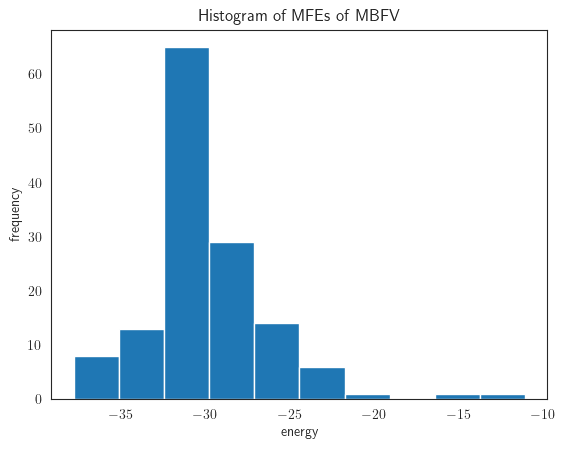

In [23]:
plt.hist(mfes)
plt.title('Histogram of MFEs of MBFV')
plt.xlabel('energy')
plt.ylabel('frequency')

# Infrared

## load data

In [24]:
# load data into dataframe
seqs_file_ir = os.path.join(base_folder, 'thesis/data/TBFV_multiple_designs_wo_opt.csv')
df = pd.read_csv(seqs_file_ir, index_col=0)

In [25]:
# set target structure of infrared model
target_structures = ['..(((((((..(((((((......(((((.........))))).(((((((............))))))).)))))))..)))))))...........................',
		      		 '.....................(((..............................................................................))).........',
		      		 '......................................................(((((((..............................................)))))))']

In [26]:
# get frequencies and the structures for each sequence
structures = []
#if tbi:
#    frequencies = []
    
for i in range(len(df)):
    seq = df.iloc[i]['sequence']
    ss = remove_positioned_gaps(seq, target_structures[0])
    structures.append(ss)
    # if tbi:
    #    frequencies.append(target_frequency(seq, ss))



In [27]:
# create and save infrared df
df.insert(1, "structure", structures, True)
#if tbi:
#    df.insert(2, "frequency", frequencies, True)

df_IR = df

## fast alignment based on target structure

In [28]:
# create a fasta file with designed sequence and target structure for a fast alignment
IR_seqs_strc_file = os.path.join(base_folder, 'thesis/data/TBFV_seqs_struct_wo_optimization.fa')

with open(IR_seqs_strc_file, 'w') as f:
    for i in range(len(df_IR)):
        seq = df_IR.iloc[i]['sequence']
        ss = df_IR.iloc[i]['structure']
        f.write(f'>seq_{i}\n')
        f.write(seq.replace('-', ''))
        f.write('\n')
        f.write(f'{ss} #S') 
        f.write('\n')
        #print(df.iloc[i]['structure']) #.replace('-', '')

In [29]:
IR_seqs_strc_file

'/Users/katringutenbrunner/Desktop/MA/github/MA/thesis/data/TBFV_seqs_struct_wo_optimization.fa'

In [30]:
# create a fasta file with sequences
IR_seqs_file = os.path.join(base_folder, 'thesis/data/TBFV_sequences_wo_optimization.fa')
with open(IR_seqs_file, 'w') as f:
    for i in range(len(df_IR)):
        seq = df_IR.iloc[i]['sequence']
        f.write(f'>seq_{i}\n')
        f.write(seq)
        f.write('\n')
        #print(df.iloc[i]['structure']) #.replace('-', '')

In [31]:
# run RNAalifold to align the sequences
!RNAalifold {IR_seqs_file}

1000 sequences; length of alignment 114.
AGUUUUUU___UUUU__GGCAGCGCGC__CUAA_______GUGACGGG___AGGU_GGUC_GC___CCCGAC__UUUUU__UUUUUUGAUUGACUAAG__UUUGUGA_GACC_U
..((((((...((((..(......(((.............))).((((..................)))).)..))))...))))))........................... (-19.75 = -12.14 +  -7.60)


In [32]:
# manually get the consensus sequence from RNAalifold
IR_cons_seq = 'AGUUUUUU___UUUU__GGCAGCGCGC__CUAA_______GUGACGGG___AGGU_GGUC_GC___CCCGAC__UUUUU__UUUUUUGAUUGACUAAG__UUUGUGA_GACC_U'.replace('_', '-')

## Logo

Text(0, 0.5, 'Counts')

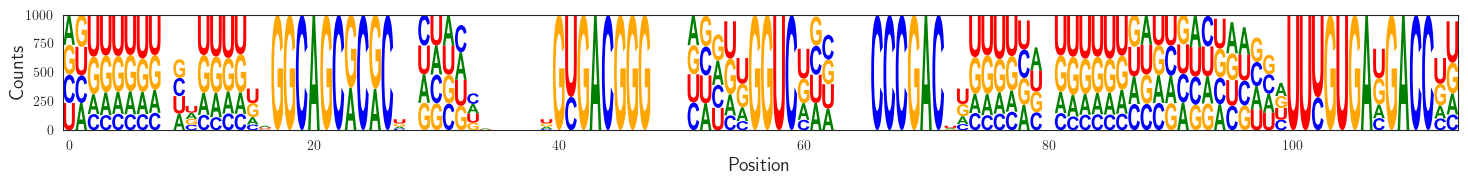

In [33]:
#Creating Counts Sequence Logo
alignment = AlignIO.read(IR_seqs_file, "fasta")

sequences = [str(record.seq) for record in alignment]
alignment_df = logomaker.alignment_to_matrix(sequences)

logo = logomaker.Logo(alignment_df, figsize=(18,1.5), color_scheme="classic")

logo.ax.set_xlabel('Position',fontsize=14)
logo.ax.set_ylabel("Counts", labelpad=-1,fontsize=14)

## shannon entropy

In [34]:
# calculate the shannon entropy for each position
alignment = AlignIO.read(IR_seqs_file, "fasta")
n = alignment.get_alignment_length()
N = len(alignment)

shannon_entropies = []
chars = list('ACGU')
for i in range(n):
    col = alignment[:, i].upper()
    unique_chars = set(col)
    frequencies = [ col.count(char)/N for char in unique_chars]
    shannon = - np.sum([freq * np.log2(freq) for freq in frequencies])
    shannon_entropies.append(shannon)

cons_seq = IR_cons_seq
ss =  target_structures[0]
v = varnaapi.Structure(sequence=cons_seq, structure=ss)


v.update(baseNum='black', drawBackbone=True, drawBases=True, fillBases=True, spaceBetweenBases=1, flat=True, resolution=2.5)
v.add_colormap(shannon_entropies, vMin=0, vMax=2, style='energy')

#v.flip(100)

#v.show()
# v.savefig('/scr/aldea/kgutenbrunner/working/thesis/images/infrared_shannon_entropy.png')

## base pairing heatmap

In [35]:
# calculate the mfe structure for each sequence and create a heatmap of it

bps = []

for i in range(len(df_IR)):
    seq = df_IR.iloc[i]['sequence']
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    BPP = fc.bpp()
    # Create the mirrored array
    mirrored_array = np.triu(BPP) + np.triu(BPP, 1).T
    bps.append(np.array(mirrored_array))

bps = np.sum(bps, axis=0)
bps /= len(df_IR)
IR_bps = bps


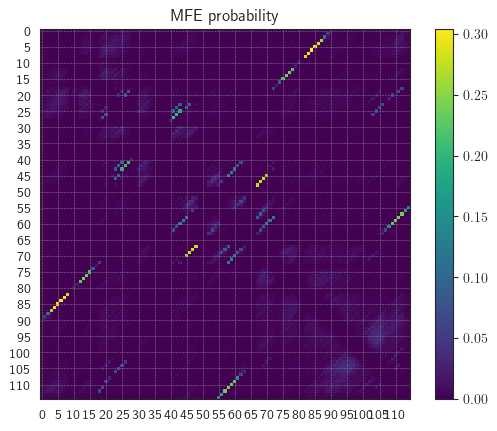

<Figure size 640x480 with 0 Axes>

In [36]:
# plot mfes
#save_fig
bp_plot(np.nan_to_num(IR_bps))


## length distribution

In [37]:
# get lengths of each sequence
# two nt are added to the beginning
sequence_lengths = [get_length(df_IR.iloc[i]['sequence']) - 2 for i in range(len(df_IR))]


Min: 78
Max: 94
Mean: 87.55


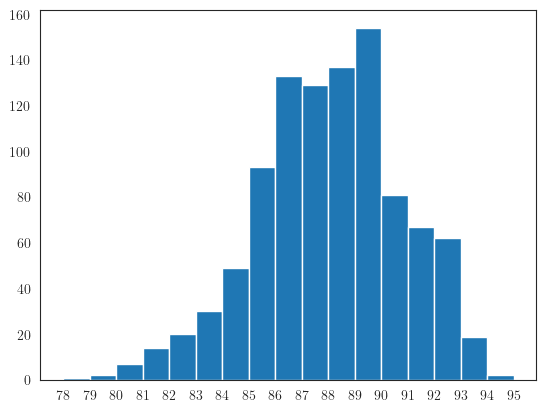

In [38]:
# plot histogram of lengths
min_value = int(min(sequence_lengths))  # Minimum value in the data
max_value = int(max(sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(sequence_lengths, bins=bins)
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.xticks(bins)
print('Min:', np.min(sequence_lengths))
print('Max:', np.max(sequence_lengths))
print('Mean:', round(np.mean(sequence_lengths),2))

In [39]:
IR_sequence_lengths = sequence_lengths

## boxplot of lengths

In [40]:
# get all the lengths of the different parts of the ss
alpha_lens =[]
alpha_stem_lens = []
alpha_bulge_lens = []
beta_stem_lens =[]
beta_hl_lens =[]
beta_lens=[]
gamma_stem_lens =[]
gamma_hl_lens  = []
gamma_lens  = []
pk2_lens  = []
until_pk1_lens  = []
before_pk2_lens  = []
after_pk2_lens = []
between_pks_lens = []

In [41]:
# manually set the regions to get part lengths
IR_sequences = list(df_IR['sequence'])
for seq in IR_sequences:    
    alpha = get_length(seq[2:18]) + get_length(seq[71:87])
    alpha_bulge = get_length(seq[9:11]) + get_length(seq[78:80]) 
    alpha_stem = alpha-alpha_bulge

    beta = get_length(seq[24:43])
    beta_hl = get_length(seq[29:38])
    beta_stem = beta-beta_hl
 

    gamma = get_length(seq[44:70] )
    gamma_hl = get_length(seq[51:63] )
    gamma_stem = gamma-gamma_hl

    pk2_len = get_length(seq[54:61]) * 2
    until_pk1 = get_length(seq[87:102])
    between_pks = get_length(seq[105:107])
    before_pk2 = get_length(seq[51:54])
    after_pk2 = get_length(seq[61:63])

    alpha_lens.append(alpha)
    alpha_stem_lens.append(alpha_stem)
    alpha_bulge_lens.append(alpha_bulge)
    beta_stem_lens.append(beta_stem)
    beta_hl_lens.append(beta_hl)
    beta_lens.append(beta)
    gamma_stem_lens.append(gamma_stem)
    gamma_hl_lens.append(gamma_hl)
    gamma_lens.append(gamma)
    pk2_lens.append(pk2_len)
    until_pk1_lens.append(until_pk1)
    between_pks_lens.append(between_pks)
    before_pk2_lens.append(before_pk2)
    after_pk2_lens.append(after_pk2)

In [42]:
# create panda dataframe to save lengths
lens_dict = {
    'alpha_stems_lens': alpha_stem_lens,
    'aplha_bulge_lens' : alpha_bulge_lens,
    'alpha_lens': alpha_lens,
    'beta_stem_lens': beta_stem_lens,
    'beta_hl_lens': beta_hl_lens,
    'beta_lens': beta_lens,
    'gamma_stem_lens': gamma_stem_lens,
    'gamma_hl_lens': gamma_hl_lens,
    'gamma_lens': gamma_lens,
    'until_pk1_lens': until_pk1_lens,
    'between_pks_lens':between_pks_lens,
    'pk2_lens': pk2_lens,
    'before_pk2_lens': before_pk2_lens,
    'after_pk2_lens': after_pk2_lens,
}
df_IR_lens = pd.DataFrame(lens_dict)

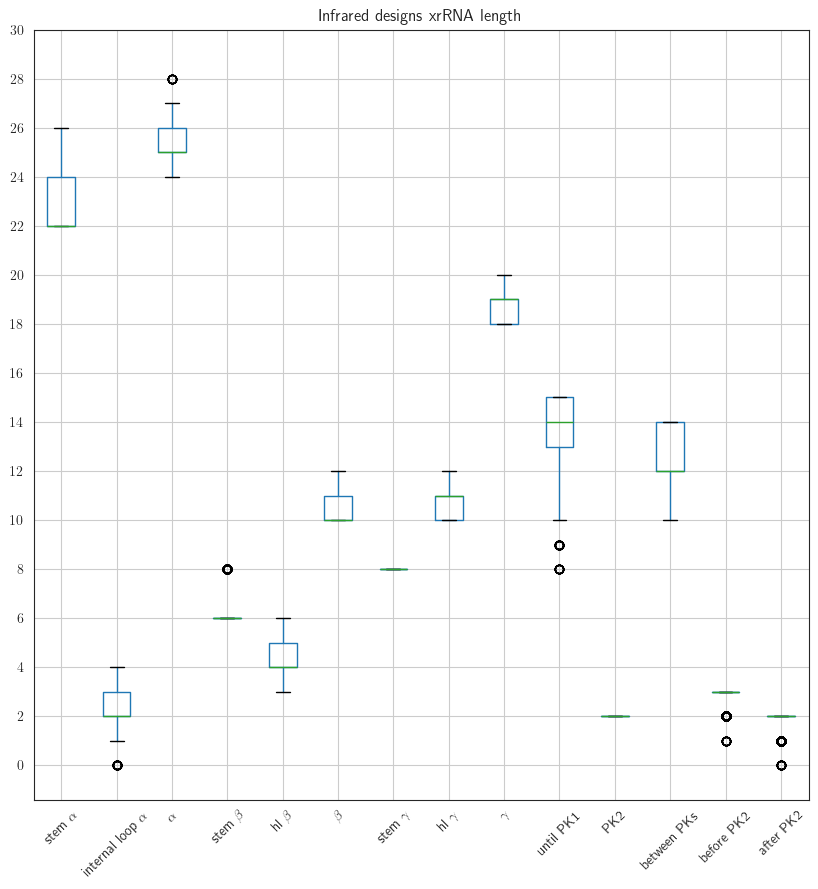

In [43]:
# create boxplot of different lengths

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 10))
df_IR_lens.boxplot()
plt.title('Infrared designs xrRNA length')

labels = [r'stem $\alpha$', r'internal loop $\alpha$',r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'until PK1', 'PK2', 'between PKs', 'before PK2', 'after PK2']
plt.xticks(list(range(1, len(labels)+1)), labels, rotation=45)
plt.yticks(np.arange(0, 32, step=2))
plt.show()
# save_file = os.path.join(base_folder, 'thesis/images/xrRNA_analysis_boxplot.png')
# plt.savefig(save_file)

## length distribution before and after optimization

In [44]:
#csv_folder = os.path.join(base_folder, 'xrRNA_design/TBFV_design/data/seqs/before_after_opt/')
#csv_files = [os.path.join(csv_folder, file) for file in os.listdir(csv_folder) if file.endswith('csv')]


In [45]:
# all_seqs = pd.DataFrame(columns=['before', 'after'])
# for file in csv_files:
#     df = pd.read_csv(csv_files[0])
#     all_seqs = pd.concat([all_seqs, df], ignore_index=True)

# df_lengths = pd.DataFrame(columns=['before', 'after'])

# lengths_before = [len(i.replace('-', '')) for i in all_seqs['before']]
# lengths_after = [len(i.replace('-', '')) for i in all_seqs['after']]
# differences = [lengths_after[i] - lengths_before[i] for i in range(len(lengths_after))]

# min_value = int(min(lengths_before))  # Minimum value in the data
# max_value = int(max(lengths_before))  # Maximum value in the data
# bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
# plt.hist(lengths_before, bins = bins, alpha=0.6, color = '#003f5c')
# plt.hist(lengths_after, bins =bins, alpha=0.8, color='#ffa600')
# plt.xticks(list(range(55, 73)))
# plt.legend(['before', 'after'], title='Optimization', frameon=True)

# plt.show()



## Pseudo knots

In [46]:
possible_PK1_region = find_structure(target_structures[1])[0]
hard_constraints_pk1 = ['.' if i in possible_PK1_region else 'x' for i in range(len(target_structures[0])) ]
hard_constraints_pk1 = ''.join(hard_constraints_pk1)

possible_PK2_region = find_structure(target_structures[2])[0]
hard_constraints_pk2 = ['.' if i in possible_PK2_region else 'x' for i in range(len(target_structures[0])) ]
hard_constraints_pk2 = ''.join(hard_constraints_pk2)

In [47]:
# both PKs
# get hard constraints for the secondary structure

possible_PK_regions = possible_PK2_region + possible_PK1_region

hard_constraints_both = ['.' if i in possible_PK_regions else 'x' for i in range(len(target_structures[0])) ]
hard_constraints_both = ''.join(hard_constraints_both)


for i in target_structures: print(i)
print(hard_constraints_pk1)
print(hard_constraints_pk2)
print(hard_constraints_both)

..(((((((..(((((((......(((((.........))))).(((((((............))))))).)))))))..)))))))...........................
.....................(((..............................................................................))).........
......................................................(((((((..............................................)))))))
xxxxxxxxxxxxxxxxxxxxx...xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx...xxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx.......xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx.......
xxxxxxxxxxxxxxxxxxxxx...xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx.......xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx...xx.......


In [48]:
# count if there is a base pair and also how many bps are there
IR_pk1_counter = 0
IR_pk1_bps = []
IR_pk2_counter = 0
IR_pk2_bps = []
IR_both_pks = 0

for seq in IR_sequences:
    PK1 = False
    PK2 = False
    # Create a fold compound with constraints
    constraint_pk1 = remove_positioned_gaps(seq, hard_constraints_pk1)
    constraint_pk2 = remove_positioned_gaps(seq, hard_constraints_pk2)

    culled_seq = seq.replace('-', '')
    fc = RNA.fold_compound(culled_seq)

    # Apply the constraint
    fc.hc_add_from_db(constraint_pk1)

    # Compute the secondary structure with the constraint applied
    structure_pk1, mfe_pk1 = fc.mfe()

    if mfe_pk1 != 0:
        print(structure_pk1)
        if bp_between_regions(constraint_pk1, structure_pk1):
            IR_pk1_counter += 1
            IR_pk1_bps.append(count_bp_between_regions(constraint_pk1, structure_pk1))
            PK1 = True


    fc = RNA.fold_compound(culled_seq)

    # Apply the constraint
    fc.hc_add_from_db(constraint_pk2)

    # Compute the secondary structure with the constraint applied
    structure_pk2, mfe_pk2 = fc.mfe()  # mfe() computes the Minimum Free Energy (MFE) secondary structure

    if mfe_pk2 != 0:

        if bp_between_regions(constraint_pk2, structure_pk2):

            IR_pk2_counter += 1
            IR_pk2_bps.append(count_bp_between_regions(constraint_pk2, structure_pk2))
            PK2 = True


    if PK1 and PK2:
        print(structure_pk1)
        print(structure_pk2)


        
IR_pk1_counter /= len(IR_sequences)
IR_pk2_counter /= len(IR_sequences)


print('\nPK1:\t\t\t', IR_pk1_counter)
print('mean # of PK1 bps:\t', round(np.mean(IR_pk1_bps), 2))

print('\nPK2:\t\t\t', IR_pk2_counter)
print('mean # of PK2 bps:\t', round(np.mean(IR_pk2_bps), 2))





PK1:			 0.0
mean # of PK1 bps:	 nan

PK2:			 1.0
mean # of PK2 bps:	 6.09


/Users/katringutenbrunner/miniconda3/envs/thesis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katringutenbrunner/miniconda3/envs/thesis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Covariance Model

## create CM model


In [49]:
# used the stk files we used already in the MBFV analysis
stk_files_CM = stk_files

In [50]:
# create and fasta file from all the sequences

output_fa_CM = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/combined.fa')
with open(output_fa_CM, 'w') as f:
    for stk_file in stk_files_CM:
        align = AlignIO.read(stk_file, "stockholm")
        for record in align:
            
            f.write(f'>{record.id}\n')
            f.write(f'{record.seq}\n')
            f.write(f"{align.column_annotations['secondary_structure']} #S\n")

In [51]:
# use mlocarna to create a alignment file
# !mlocarna $output_fa_CM

In [52]:
# save the output consensus secondary structure from mlocarna
alifold = '.........(.(((((..((.((((......(((.........))).((((............)))).)))).)))))))..)..........................'

In [53]:
# create a stockholm file based on the mlocarna alignment

# get the alignment file
input_file = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/combined.out/results/result.aln')
# output name for the stockholm file
align_stk_file = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/alignment.stk')

input_file = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/combined.out/results/result.aln')


## Load the Clustal alignment
#alignment = AlignIO.read(input_file, "clustal")
## add the secondary structure from mlocarna manually
# alignment.column_annotations["secondary_structure_cons"] = alifold
# alignment.column_annotations['secondary_structure'] = alifold

## Write the alignment in Stockholm format
#AlignIO.write(alignment, align_stk_file, "stockholm")

In [54]:
# create the covariance model based on the stockholm we just created
# !cmbuild /scr/aldea/kgutenbrunner/working/cov_model/TBFV_xrRNA1/TBFV_xrRNA1.cm $stk_file

## load data designs

In [55]:
# load the just create model
cm_model = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/TBFV_xrRNA1.cm')
designs_file_CM = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/designed_sequences.out')

In [56]:
# create 100 sequences from the model
# !cmemit -N 100 -a -o $designs_file_CM $cm_model

In [57]:
align = AlignIO.read(designs_file_CM, "stockholm")

SS_cons = align.column_annotations['secondary_structure']
RF = align.column_annotations['reference_annotation']

## Logo Counts

Text(0, 0.5, 'Counts')

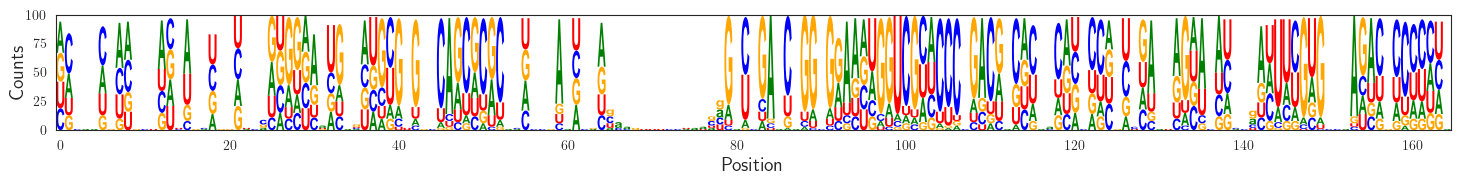

In [58]:
#Creating Counts Sequence Logo
alignment = AlignIO.read(designs_file_CM, "stockholm")

sequences = [str(record.seq) for record in alignment]
alignment_df = logomaker.alignment_to_matrix(sequences)

logo = logomaker.Logo(alignment_df, figsize=(18,1.5), color_scheme="classic")

logo.ax.set_xlabel('Position',fontsize=14)
logo.ax.set_ylabel("Counts", labelpad=-1,fontsize=14)

In [59]:
# plt.savefig('/scr/aldea/kgutenbrunner/working/cov_model/MBFV_xrRNA1/logo.pdf')


## shannon entropy

In [60]:
# creat the shannon entropy of CM designs

alignment = AlignIO.read(designs_file_CM, "stockholm")
n = alignment.get_alignment_length()
N = len(alignment)

shannon_entropies = []
chars = list('ACGU')
for i in range(n):
    col = alignment[:, i].upper()
    unique_chars = set(col)
    frequencies = [ col.count(char)/N for char in unique_chars]
    shannon = - np.sum([freq * np.log2(freq) for freq in frequencies])
    shannon_entropies.append(shannon)

seq = RF
ss = SS_cons
v = varnaapi.Structure(sequence=seq, structure=ss)


v.update(baseNum='black', drawBackbone=True, drawBases=True, fillBases=True, spaceBetweenBases=1, flat=True, resolution=2.5)
v.add_colormap(shannon_entropies, vMin=0, vMax=2, style='energy')

#v.flip(100)
# v.savefig('/scr/aldea/kgutenbrunner/working/thesis/images/CM_shannon_entropy.png')
v.show()

Output file: /var/folders/54/ry4wc1s953jdm1j76gdcpwpc0000gn/T/tmp1ikg1f3u.svg



JupyterSvgImage(svg='<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" \n"http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n\n<svg width="600px" height="379px" version="1.1" viewBox="0 0 1100 700" \nxmlns="http://www.w3.org/2000/svg">\n<line x1="15.0" y1="608.9458978289664" x2="22.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="32.5" y1="608.9458978289664" x2="40.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="50.0" y1="608.9458978289664" x2="57.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="67.5" y1="608.9458978289664" x2="75.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="85.0" y1="608.9458978289664" x2="92.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="102.5" y1="608.9458978289664" x2="110.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="120.0" y1="608.9458978289664" x2="127.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="137.5" y1="608.9458978289664" x2="145.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="155.0" y1="608.9458978289664" x2="162.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="172.5" y1="608.9458978289664" x2="180.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="190.0" y1="608.9458978289664" x2="197.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="207.5" y1="608.9458978289664" x2="215.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="225.0" y1="608.9458978289664" x2="232.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="242.5" y1="608.9458978289664" x2="250.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="260.0" y1="608.9458978289664" x2="267.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="277.5" y1="608.9458978289664" x2="285.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="295.0" y1="608.9458978289664" x2="302.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="312.5" y1="608.9458978289664" x2="320.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="330.0" y1="608.9458978289664" x2="337.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="347.5" y1="608.9458978289664" x2="355.0" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="365.0" y1="608.9458978289664" x2="372.5" y2="608.9458978289664" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="374.534376925372" y1="604.9203444782786" x2="370.0859391782882" y2="598.8820101965878" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="367.12031659989276" y1="589.8564568459" x2="367.1203173442421" y2="582.3564515600935" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="370.0859417141469" y1="573.3308987980613" x2="374.5343806597978" y2="567.2925653993544" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="382.27531453670764" y1="561.7849821474271" x2="389.4382845898369" y2="559.5619348458391" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="396.23016748904905" y1="553.5045973984579" x2="399.2550791445754" y2="546.6415182749918" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="402.24214183768765" y1="537.1613005585161" x2="404.183121431963" y2="527.351479040537" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="406.1241010262384" y1="517.5416575225578" x2="408.0650806205137" y2="507.73183600457867" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="408.9132799219077" y1="497.82842096584193" x2="408.7298410

## base pairing heatmap

In [61]:

structures = []
records = list(SeqIO.parse(designs_file_CM, "stockholm"))
# calculate the mfe structure for each sequence and create a heatmap of it
bps = []

for record in records:
    seq = str(record.seq)
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    BPP = fc.bpp()
    # Create the mirrored array
    mirrored_array = np.triu(BPP) + np.triu(BPP, 1).T
    bps.append(np.array(mirrored_array))

bps = np.sum(bps, axis=0)
bps /= len(records)
CM_bps = bps


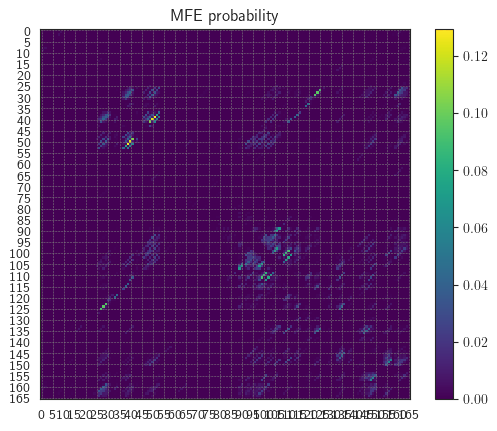

<Figure size 640x480 with 0 Axes>

In [62]:
bp_plot(np.nan_to_num(bps))

## length distribution

In [63]:
records = list(SeqIO.parse(designs_file_CM, "stockholm"))
CM_design_sequences = [str(record.seq) for record in records]


In [64]:
alpha, _, _ = find_structure(SS_cons)
alpha_begin = alpha[0]

In [65]:
# get lengths of each sequence
# only use length starting from the alpha stem, and subtract some from the back like 3, because sequences have some nts after PK2
sequence_lengths = [get_length(seq[alpha_begin:]) - 3 for seq in CM_design_sequences]


(array([ 2.,  1.,  3.,  7., 18., 40., 24.,  3.,  1.,  1.]),
 array([70. , 72.9, 75.8, 78.7, 81.6, 84.5, 87.4, 90.3, 93.2, 96.1, 99. ]),
 <BarContainer object of 10 artists>)

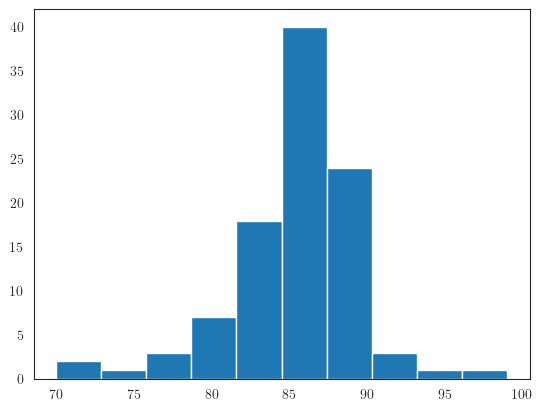

In [66]:
# plot histogram of lengths
plt.hist(sequence_lengths)

In [67]:
CM_sequence_lengths = sequence_lengths

## boxplot of lengths

In [68]:
# get all the lengths of the different parts of the ss
alpha_lens =[]
alpha_stem_lens =[]
beta_stem_lens =[]
beta_hl_lens =[]
beta_lens=[]
gamma_stem_lens =[]
gamma_hl_lens  = []
gamma_lens  = []

structures = find_structure(SS_cons)
for seq in CM_design_sequences:
    alpha_stem, alpha, beta_stem, beta_hl, beta, gamma_stem, gamma_hl, gamma = get_length_of_structures(seq, structures)
    alpha_lens.append(alpha)
    alpha_stem_lens.append(alpha_stem)
    beta_stem_lens.append(beta_stem)
    beta_hl_lens.append(beta_hl)
    beta_lens.append(beta)
    gamma_stem_lens.append(gamma_stem)
    gamma_hl_lens.append(gamma_hl)
    gamma_lens.append(gamma)

In [69]:
SS_cons

'::...:.::...::.:..:..(...(((((-.((..-((((.,..,,,,,<<<.._..._._.._..............>.>.>,.<.<<.<____________>>>.>,)).))-..))).))).).):..::::.::...::::::::...::::.::::::.'

In [70]:
lens_dict = {
    'alpha_stems_lens': alpha_stem_lens,
    'alpha_lens': alpha_lens,
    'beta_stem_lens': beta_stem_lens,
    'beta_hl_lens': beta_hl_lens,
    'beta_lens': beta_lens,
    'gamma_stem_lens': gamma_stem_lens,
    'gamma_hl_lens': gamma_hl_lens,
    'gamma_lens': gamma_lens,
}

df_CM_lens = pd.DataFrame(lens_dict)

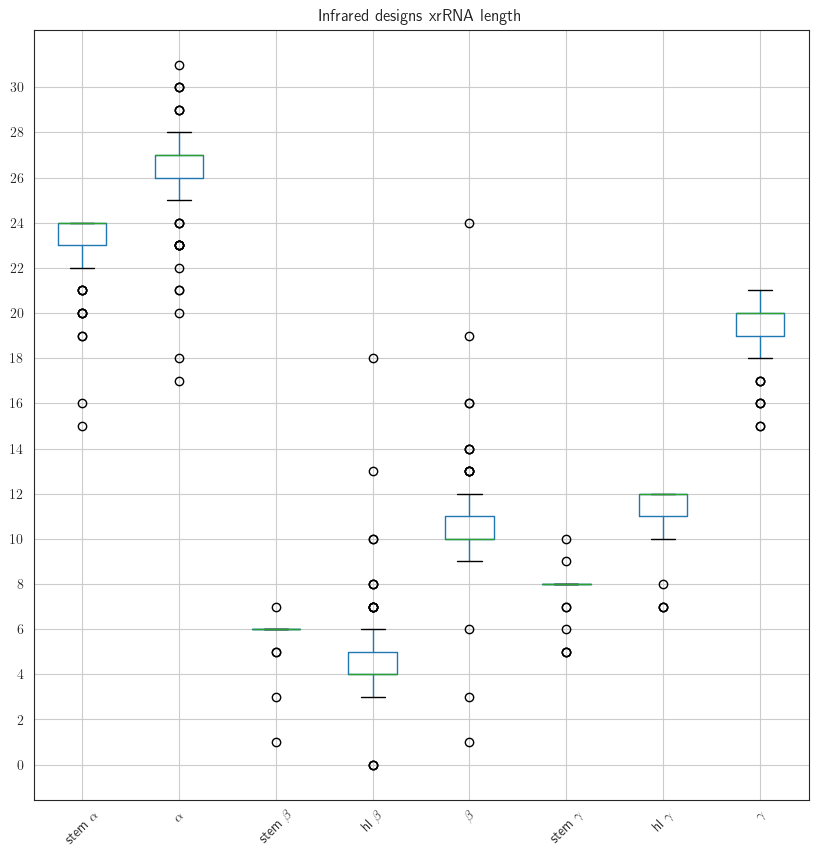

In [71]:
# create boxplot of different lengths

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 10))
df_CM_lens.boxplot()
plt.title('Infrared designs xrRNA length')


labels = [r'stem $\alpha$', r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$']
plt.xticks(list(range(1, len(labels)+1)), labels, rotation=45)
plt.yticks(np.arange(0, 32, step=2))
plt.show()
# save_file = os.path.join(base_folder, 'thesis/images/xrRNA_analysis_boxplot.png')
# plt.savefig(save_file)

## Pseudo knots

In [72]:
alpha,beta, gamma = find_structure(SS_cons)

In [73]:
# PK1
# get hard constraints for the secondary structure

# region A is within multi loop, between alpha and beta stem
possible_PK1_region_A = list(range(alpha[int(len(alpha)/2)-1] + 1, beta[0]))
# region B is after alpha stem until 3' end
possible_PK1_region_B = list(range(alpha[-1]+1, len(SS_cons) - 5 ))
possible_PK1_region = possible_PK1_region_A + possible_PK1_region_B

hard_constraints_pk1 = ['.' if i in possible_PK1_region else 'x' for i in range(len(SS_cons)) ]
hard_constraints_pk1 = ''.join(hard_constraints_pk1)

# PK2
# get hard constraints for the secondary structure
# region A is within beta hairpin
possible_PK2_region_A = list(range(beta[int(len(beta)/2)-1]+1, beta[int(len(beta)/2)]))
# region B is after alpha stem until 3' end
possible_PK2_region_B = list(range(alpha[-1]+6, len(SS_cons)))
possible_PK2_region = possible_PK2_region_A + possible_PK2_region_B

hard_constraints_pk2 = ['.' if i in possible_PK2_region else 'x' for i in range(len(SS_cons)) ]
hard_constraints_pk2 = ''.join(hard_constraints_pk2)


# both PKs
# get hard constraints for the secondary structure

possible_PK_regions = possible_PK2_region + possible_PK1_region

hard_constraints_both = ['.' if i in possible_PK_regions else 'x' for i in range(len(SS_cons)) ]
hard_constraints_both = ''.join(hard_constraints_both)


print(SS_cons)
print(hard_constraints_pk1)
print(hard_constraints_pk2)
print(hard_constraints_both)

::...:.::...::.:..:..(...(((((-.((..-((((.,..,,,,,<<<.._..._._.._..............>.>.>,.<.<<.<____________>>>.>,)).))-..))).))).).):..::::.::...::::::::...::::.::::::.
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx.........xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx...............................xxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx..........................xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx...............................
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx.........xxx..........................xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx....................................


In [74]:
# count if there is a base pair and also how many bps are there
CM_pk1_counter = 0
CM_pk1_bps = []
CM_pk2_counter = 0
CM_pk2_bps = []
CM_both_pks = 0

for seq in CM_design_sequences:
    PK1 = False
    PK2 = False
    # Create a fold compound with constraints
    constraint_pk1 = remove_positioned_gaps(seq, hard_constraints_pk1)
    constraint_pk2 = remove_positioned_gaps(seq, hard_constraints_pk2)

    culled_seq = seq.replace('-', '')
    fc = RNA.fold_compound(culled_seq)

    # Apply the constraint
    fc.hc_add_from_db(constraint_pk1)

    # Compute the secondary structure with the constraint applied
    structure_pk1, mfe_pk1 = fc.mfe()

    if mfe_pk1 != 0:
        if bp_between_regions(constraint_pk1, structure_pk1):
            CM_pk1_counter += 1
            CM_pk1_bps.append(count_bp_between_regions(constraint_pk1, structure_pk1))
            PK1 = True



    fc = RNA.fold_compound(culled_seq)

    # Apply the constraint
    fc.hc_add_from_db(constraint_pk2)

    # Compute the secondary structure with the constraint applied
    structure_pk2, mfe_pk2 = fc.mfe()  # mfe() computes the Minimum Free Energy (MFE) secondary structure

    if mfe_pk2 != 0:

        if bp_between_regions(constraint_pk2, structure_pk2):

            CM_pk2_counter += 1
            CM_pk2_bps.append(count_bp_between_regions(constraint_pk2, structure_pk2))
            PK2 = True


    if PK1 and PK2:
        print(structure_pk1)
        print(structure_pk2)


        
CM_pk1_counter /= len(CM_design_sequences)
CM_pk2_counter /= len(CM_design_sequences)


print('\nPK1:\t\t\t', CM_pk1_counter)
print('mean # of PK1 bps:\t', round(np.mean(CM_pk1_bps), 2))

print('\nPK2:\t\t\t', CM_pk2_counter)
print('mean # of PK2 bps:\t', round(np.mean(CM_pk2_bps), 2))





PK1:			 0.08
mean # of PK1 bps:	 4.38

PK2:			 0.06
mean # of PK2 bps:	 5.17


In [75]:
CM_both_pks = 0
both_structures = []


for seq in CM_design_sequences:
    PK1 = False
    PK2 = False
    constraint_pk1 = remove_positioned_gaps(seq, hard_constraints_pk1)
    constraint_pk2 = remove_positioned_gaps(seq, hard_constraints_pk2)

    culled_seq = seq.replace('-', '')
    fc = RNA.fold_compound(culled_seq)

    fc.hc_add_from_db(constraint_pk1)

    structure_pk1, mfe_pk1 = fc.mfe()

    if mfe_pk1 != 0:
        if bp_between_regions(constraint_pk1, structure_pk1):
            cur_pk1_end = find_structure(structure_pk1)[0][-1]
            updated_pk2_constraint = constraint_pk2[:50] + ''.join('x' * (cur_pk1_end - 49)) +constraint_pk2[cur_pk1_end+1:]

            fc = RNA.fold_compound(culled_seq)

            fc.hc_add_from_db(updated_pk2_constraint)

            structure_pk2, mfe_pk2 = fc.mfe() 

            if mfe_pk2 != 0:
                if bp_between_regions(updated_pk2_constraint, structure_pk2):
                    CM_both_pks += 1
                    both_structures.append(structure_pk1, structure_pk2)


print('\nPK1:\t\t\t', CM_both_pks)




PK1:			 0


In [76]:
CM_both_pks = 0
both_structures = []


for seq in CM_design_sequences:
    PK1 = False
    PK2 = False
    constraint_pk1 = remove_positioned_gaps(seq, hard_constraints_pk1)
    constraint_pk2 = remove_positioned_gaps(seq, hard_constraints_pk2)

    culled_seq = seq.replace('-', '')
    fc = RNA.fold_compound(culled_seq)

    fc.hc_add_from_db(constraint_pk2)

    structure_pk2, mfe_pk2 = fc.mfe()

    if mfe_pk2 != 0:
         if bp_between_regions(constraint_pk2, structure_pk2):
            cur_pk2_start = structure_pk2.find(')')
            updated_pk1_constraint = constraint_pk1[:cur_pk2_start] + ''.join('x' * (len(structure_pk2) - cur_pk2_start))

            fc = RNA.fold_compound(culled_seq)

            fc.hc_add_from_db(updated_pk1_constraint)

            structure_pk1, mfe_pk1 = fc.mfe() 

            if mfe_pk1 != 0:
                if bp_between_regions(updated_pk1_constraint, structure_pk1):
                    CM_both_pks += 1
                    both_structures.append(structure_pk1, structure_pk2)



print('\nPK1:\t\t\t', CM_both_pks)




PK1:			 0


# all combined

## boxplot of lengths

In [77]:
rename_mapping = {
    'stemA': 'alpha_stems_lens',
 'ibA': 'aplha_bulge_lens',
 'alpha': 'alpha_lens',
 'stemB': 'beta_stem_lens',
 'hlB': 'beta_hl_lens',
 'beta': 'beta_lens',
 'stemG': 'gamma_stem_lens',
 'hlG': 'gamma_hl_lens',
 'gamma': 'gamma_lens',
 'bPK': 'until_pk1_lens',
 'n_PK': 'pk2_lens',
 'PK1bPK2': 'between_pks_lens',
 'b_PK': 'before_pk2_lens',
 'a_PK': 'after_pk2_lens'}

df_TBFV = df_TBFV.rename(columns=rename_mapping)

In [78]:
df_IR_lens['model'] = 'Infrared'
df_CM_lens['model'] = 'CM'
df_TBFV['model'] = 'TBFV'
TBFV_temp = df_TBFV.drop(columns=['len', 'name'])


combined = pd.concat([TBFV_temp, df_IR_lens, df_CM_lens], ignore_index=True, sort=False)

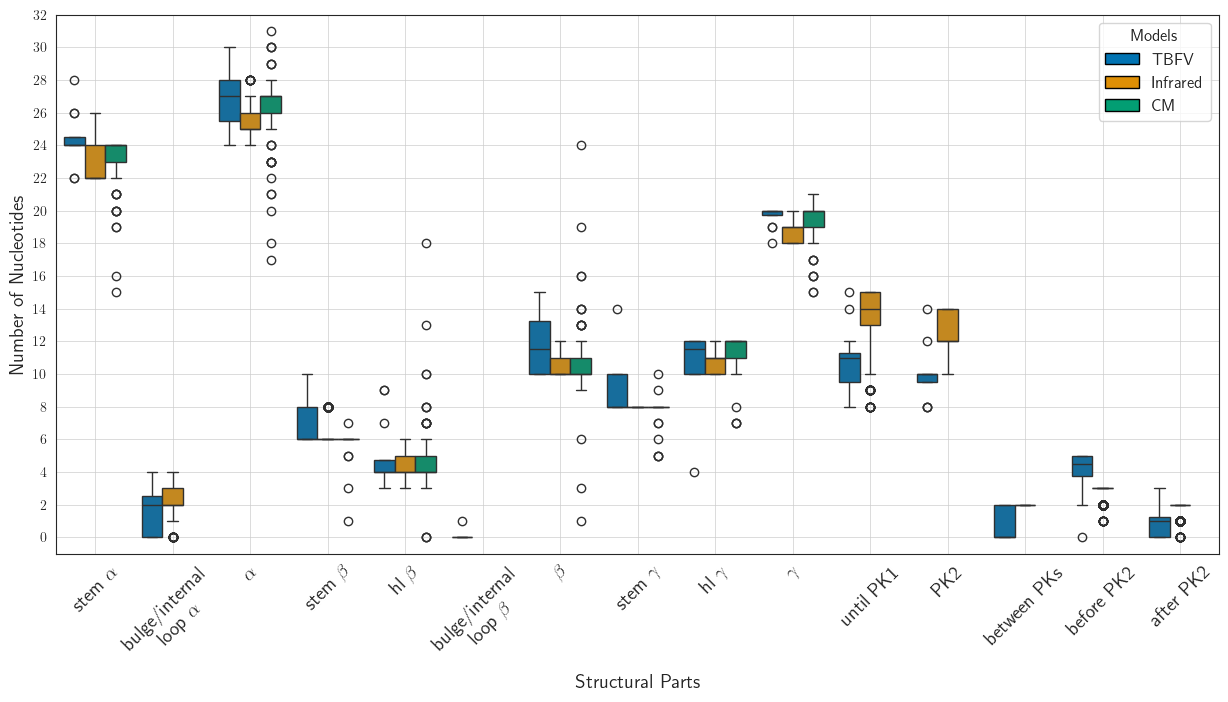

In [79]:
# Melt the DataFrame to have 'feature' as one column, and 'value' as another column
melted = pd.melt(combined, id_vars='model', var_name='feature', value_name='value')


# Create the boxplot, showing features on the x-axis, and the values on the y-axis
plt.figure(figsize=(15, 7))
sns.boxplot(x='feature', y='value', hue='model', data=melted, palette=colors[0:3])

# Set title and labels

plt.xlabel('Structural Parts', fontsize=14)
plt.ylabel('Number of Nucleotides', fontsize=14)
labels = [r'stem $\alpha$', 'bulge/internal\n' + r'loop $\alpha$', r'$\alpha$', 
          r'stem $\beta$', r'hl $\beta$', 'bulge/internal\n' + r'loop $\beta$', r'$\beta$', 
          r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'until PK1', 'PK2', 
          'between PKs', 'before PK2', 'after PK2']


plt.xticks(list(range(len(labels))), labels, rotation=45, fontsize=14)
plt.ylim(-1, 32)  # Set your limits manually if needed, adjusting to your data

plt.grid(True, which='both', linestyle='-', linewidth=0.7, alpha=0.7)
plt.yticks(np.arange(0, 34, 2))  # Adjust the step size here

legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='TBFV'),
    Patch(facecolor=colors[1], edgecolor='black', label='Infrared'),
    Patch(facecolor=colors[2], edgecolor='black', label='CM'),
]
plt.legend(handles=legend_elements, title="Models", title_fontsize=12, loc='upper right', fontsize=12) #bbox_to_anchor=(1.05, 1),

save_file = os.path.join(base_folder, 'thesis/images/TBFV_model_comparison_boxplot.png')
plt.savefig(save_file, bbox_inches='tight', dpi=300)


/var/folders/54/ry4wc1s953jdm1j76gdcpwpc0000gn/T/ipykernel_47050/1703622897.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='feature', y='value', hue='model', scale='count', data=melted, inner='quart', palette='muted')


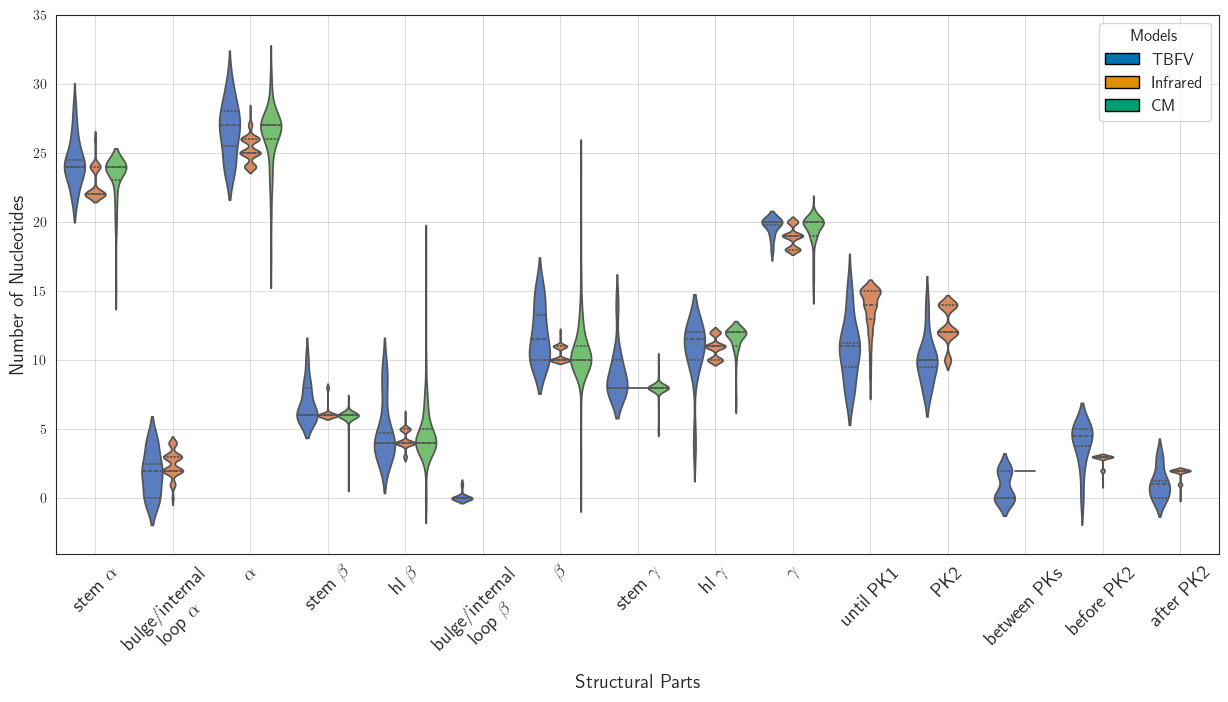

In [80]:
melted = pd.melt(combined, id_vars='model', var_name='feature', value_name='value')

plt.figure(figsize=(15, 7))
sns.violinplot(x='feature', y='value', hue='model', scale='count', data=melted, inner='quart', palette='muted')


plt.xlabel('Structural Parts', fontsize=14)
plt.ylabel('Number of Nucleotides', fontsize=14)
labels = [r'stem $\alpha$', 'bulge/internal\n' + r'loop $\alpha$', r'$\alpha$', 
          r'stem $\beta$', r'hl $\beta$', 'bulge/internal\n' + r'loop $\beta$', r'$\beta$', 
          r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'until PK1', 'PK2', 
          'between PKs', 'before PK2', 'after PK2']

plt.xticks(list(range(len(labels))), labels, rotation=45, fontsize=14)
plt.ylim(-4, 35)  # Set your limits manually if needed, adjusting to your data
plt.grid(True, which='both', linestyle='-', linewidth=0.7, alpha=0.7)

legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='TBFV'),
    Patch(facecolor=colors[1], edgecolor='black', label='Infrared'),
    Patch(facecolor=colors[2], edgecolor='black', label='CM'),
]
plt.legend(handles=legend_elements, title="Models", title_fontsize=12, loc='upper right', fontsize=12) #bbox_to_anchor=(1.05, 1),

save_file = os.path.join(base_folder, 'thesis/images/TBFV_model_comparison_violinplot.png')
plt.savefig(save_file, bbox_inches='tight', dpi=300)


## length distribution

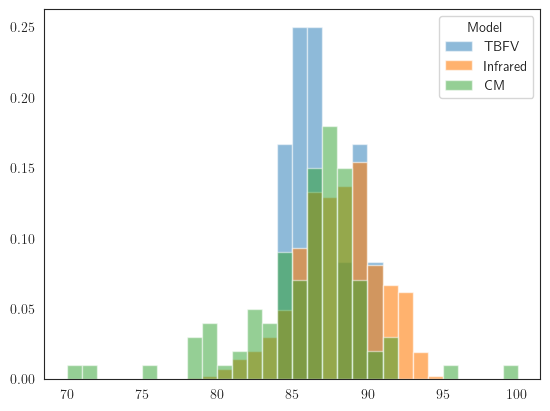

In [81]:
# plot histogram of lengths

min_value = int(min(TBFV_sequence_lengths))  # Minimum value in the data
max_value = int(max(TBFV_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(TBFV_sequence_lengths, bins=bins,  alpha=0.5,density=True)

min_value = int(min(IR_sequence_lengths))  # Minimum value in the data
max_value = int(max(IR_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(IR_sequence_lengths, bins=bins, alpha=0.6,density=True)

min_value = int(min(CM_sequence_lengths))  # Minimum value in the data
max_value = int(max(CM_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
plt.hist(CM_sequence_lengths, bins=bins, alpha=0.5, density=True)

#plt.xticks(list(range(75, 110, 1)))
plt.legend(['TBFV', 'Infrared', 'CM'], title='Model', frameon=True);

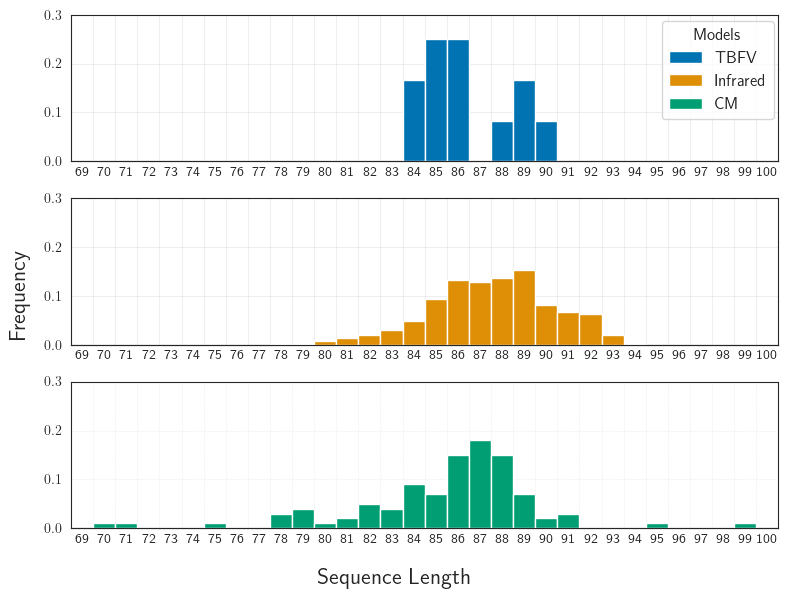

In [116]:

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,6))
linewidth = 0.5
bins = np.arange(71, 100, 1)  # +2 to include the last bin


min_value = int(min(TBFV_sequence_lengths))  # Minimum value in the data
max_value = int(max(TBFV_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax[0].hist(TBFV_sequence_lengths, bins=bins, density=True,label='MBFV', color=colors[0])


min_value = int(min(IR_sequence_lengths))  # Minimum value in the data
max_value = int(max(IR_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax[1].hist(IR_sequence_lengths, bins=bins, density=True,label='Infrared', color=colors[1])

min_value = int(min(CM_sequence_lengths))  # Minimum value in the data
max_value = int(max(CM_sequence_lengths))  # Maximum value in the data
bins = np.arange(min_value, max_value + 2, 1)  # +2 to include the last bin
ax[2].hist(CM_sequence_lengths, bins=bins, density=True,label='CM', color=colors[2])

bins = np.arange(69, 101, 1)  # +2 to include the last bin

for i in range(3):
    ax[i].set_xticks(bins, bins)
    ax[i].set_xlim(69, 101)
    ax[i].set_ylim(0, 0.30)
    ax[i].grid(linestyle='-', alpha=0.3)
    ax[i].set_xticks(bins, labels=[''] * len(bins))  # Primary x-axis labels hidden
    sec = ax[i].secondary_xaxis(location=0)
    sec.set_xticks(bins + 0.5, bins)  # Center the bins
    sec.tick_params('x', length=0)

# Add one x and y label for all subplots
fig.supylabel('Frequency', fontsize=16)
fig.supxlabel('Sequence Length', fontsize=16)


plt.grid(visible=True, which='major', axis='both', linestyle='--', linewidth=0.5)
legend_elements = [
    Patch(facecolor=colors[0], label='TBFV'),
    Patch(facecolor=colors[1], label='Infrared'),
    Patch(facecolor=colors[2], label='CM'),
]

fig.legend(handles=legend_elements, title="Models", bbox_to_anchor=(.985, 0.97), ncol=1, fontsize=12, title_fontsize=12)

#plt.legend(['MBFV', 'Infrared', 'CM'], title='Model', frameon=True)
save_file = os.path.join(base_folder, 'thesis/images/TBFV_length_dist.png')
plt.tight_layout()
plt.savefig(save_file, bbox_inches='tight', dpi=300)


In [102]:
max(CM_sequence_lengths)

99

## logo counts

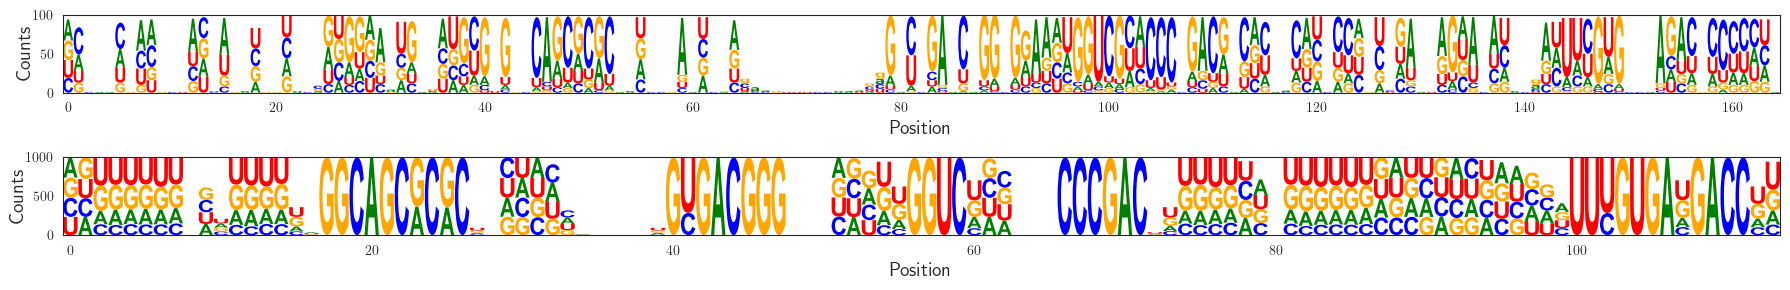

In [83]:
#Creating Counts Sequence Logo
CM_alignment = AlignIO.read(designs_file_CM, "stockholm")
CM_sequences = [str(record.seq) for record in CM_alignment]
CM_alignment_df = logomaker.alignment_to_matrix(CM_sequences)

#Creating Counts Sequence Logo
IR_alignment = AlignIO.read(IR_seqs_file, "fasta")
IR_sequences = [str(record.seq) for record in IR_alignment]
IR_alignment_df = logomaker.alignment_to_matrix(IR_sequences)

# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 3))  # Adjust height to fit both logos

# CM logo on the first subplot
logo_CM = logomaker.Logo(CM_alignment_df, ax=axes[0], color_scheme="classic")
logo_CM.ax.set_xlabel('Position', fontsize=14)
logo_CM.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# IR logo on the second subplot
logo_IR = logomaker.Logo(IR_alignment_df, ax=axes[1], color_scheme="classic")
logo_IR.ax.set_xlabel('Position', fontsize=14)
logo_IR.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

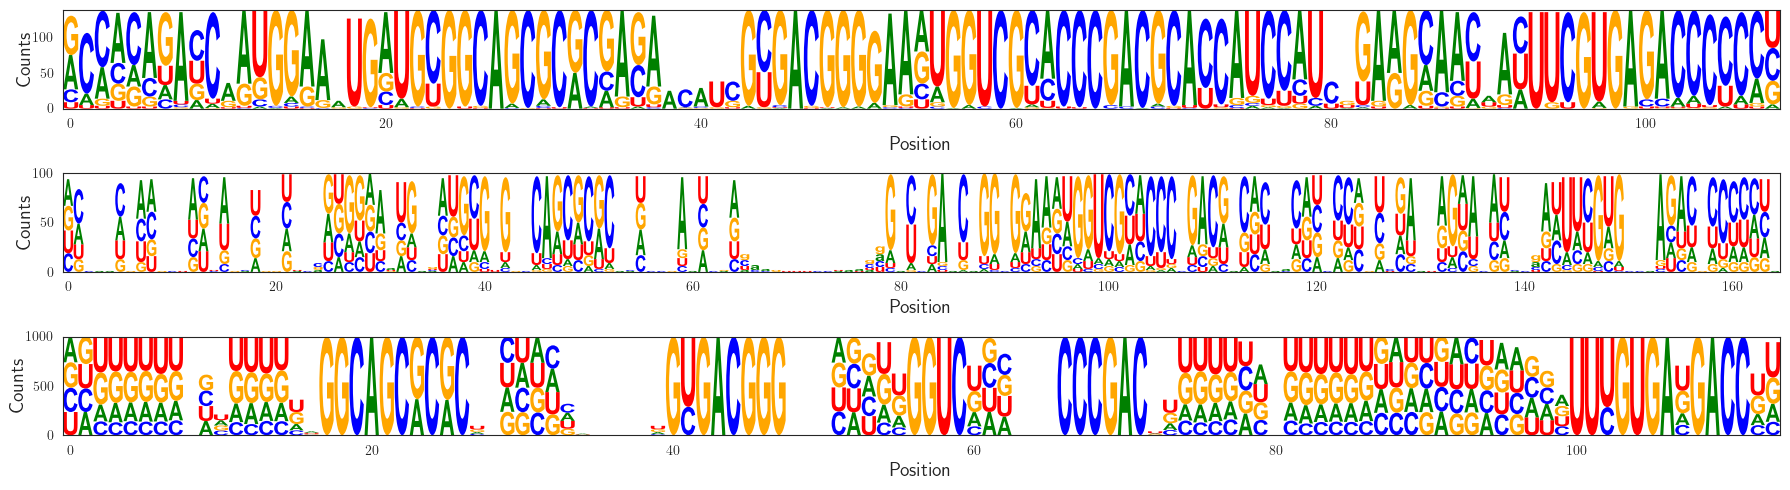

In [84]:
# Function to pad alignment matrix to a specific length
def pad_alignment_matrix(alignment_df, max_length):
    current_length = alignment_df.shape[0]
    if current_length < max_length:
        padding_df = pd.DataFrame(0, index=np.arange(current_length, max_length), columns=alignment_df.columns)
        alignment_df = pd.concat([alignment_df, padding_df])
    return alignment_df

# Creating Counts Sequence Logo from CM
CM_alignment = AlignIO.read(designs_file_CM, "stockholm")
CM_sequences = [str(record.seq) for record in CM_alignment]
CM_alignment_df = logomaker.alignment_to_matrix(CM_sequences)

# Creating Counts Sequence Logo from Infrared
IR_alignment = AlignIO.read(IR_seqs_file, "fasta")
IR_sequences = [str(record.seq) for record in IR_alignment]
IR_alignment_df = logomaker.alignment_to_matrix(IR_sequences)

# Creating Counts Sequence Logo from MBFV data
TBFV_input_file = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/stk_files/result.aln')
TBFV_alignment = AlignIO.read(TBFV_input_file, "clustal")
TBFV_sequences = [str(record.seq) for record in TBFV_alignment]
TBFV_alignment_df = logomaker.alignment_to_matrix(TBFV_sequences)

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 5))  # Adjust height to fit all logos

# MBFV logo on the first subplot
logo_TBFV = logomaker.Logo(TBFV_alignment_df, ax=axes[0], color_scheme="classic")
logo_TBFV.ax.set_xlabel('Position', fontsize=14)
logo_TBFV.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# CM logo on the second subplot
logo_CM = logomaker.Logo(CM_alignment_df, ax=axes[1], color_scheme="classic")
logo_CM.ax.set_xlabel('Position', fontsize=14)
logo_CM.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# IR logo on the third subplot
logo_IR = logomaker.Logo(IR_alignment_df, ax=axes[2], color_scheme="classic")
logo_IR.ax.set_xlabel('Position', fontsize=14)
logo_IR.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


In [117]:
# Creating Counts Sequence Logo from CM
CM_alignment = AlignIO.read(designs_file_CM, "stockholm")
CM_sequences = [str(record.seq) for record in CM_alignment]
CM_alignment_df = logomaker.alignment_to_matrix(CM_sequences)

# Creating Counts Sequence Logo from Infrared
IR_alignment = AlignIO.read(IR_seqs_file, "fasta")
IR_sequences = [str(record.seq) for record in IR_alignment]
IR_alignment_df = logomaker.alignment_to_matrix(IR_sequences)

# Creating Counts Sequence Logo from MBFV data
TBFV_input_file = os.path.join(base_folder, 'cov_model/TBFV_xrRNA1/data/combined.out/results/result.aln')
TBFV_alignment = AlignIO.read(TBFV_input_file, "clustal")
TBFV_sequences = [str(record.seq) for record in TBFV_alignment]
TBFV_alignment_df = logomaker.alignment_to_matrix(TBFV_sequences)

# Determine the maximum length among all alignments
max_length = max(CM_alignment_df.shape[0], IR_alignment_df.shape[0], TBFV_alignment_df.shape[0])

# Pad the alignments to the same length
CM_alignment_df = pad_alignment_matrix(CM_alignment_df, max_length)
IR_alignment_df = pad_alignment_matrix(IR_alignment_df, max_length)
TBFV_alignment_df = pad_alignment_matrix(TBFV_alignment_df, max_length)

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 5))  # Adjust height to fit all logos

# MBFV logo on the first subplot
logo_TBFV = logomaker.Logo(TBFV_alignment_df, ax=axes[0], color_scheme="classic")
logo_TBFV.ax.set_xlabel('Position', fontsize=14)
logo_TBFV.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# CM logo on the second subplot
logo_CM = logomaker.Logo(CM_alignment_df, ax=axes[1], color_scheme="classic")
logo_CM.ax.set_xlabel('Position', fontsize=14)
logo_CM.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# IR logo on the third subplot
logo_IR = logomaker.Logo(IR_alignment_df, ax=axes[2], color_scheme="classic")
logo_IR.ax.set_xlabel('Position', fontsize=14)
logo_IR.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/katringutenbrunner/Desktop/MA/github/MA/theses/data/IR_designs_mlocarna.fa'

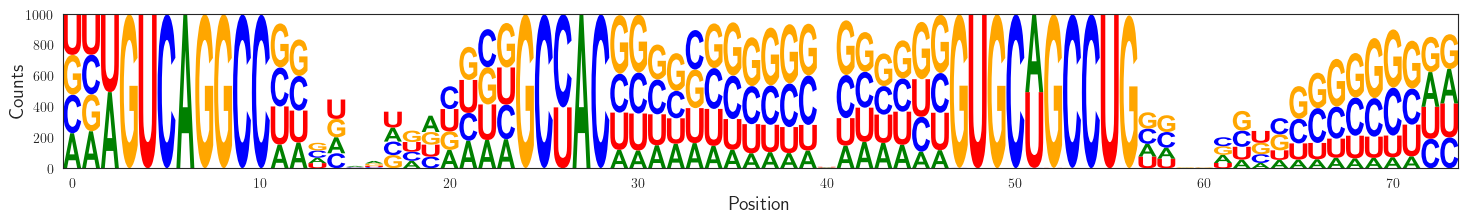

In [127]:
# Creating Counts Sequence Logo from MBFV data
TBFV_input_file = os.path.join(base_folder, 'thesis/data/MBFV_IR_designs_locarana.aln')
TBFV_alignment = AlignIO.read(TBFV_input_file, "clustal")
TBFV_sequences = [str(record.seq) for record in TBFV_alignment]
TBFV_alignment_df = logomaker.alignment_to_matrix(TBFV_sequences)



# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 2))  # Adjust height to fit all logos

# MBFV logo on the first subplot
logo_TBFV = logomaker.Logo(TBFV_alignment_df, ax=axes, color_scheme="classic")
logo_TBFV.ax.set_xlabel('Position', fontsize=14)
logo_TBFV.ax.set_ylabel("Counts", labelpad=-1, fontsize=14)


# Show the figure
plt.show()


### MFE

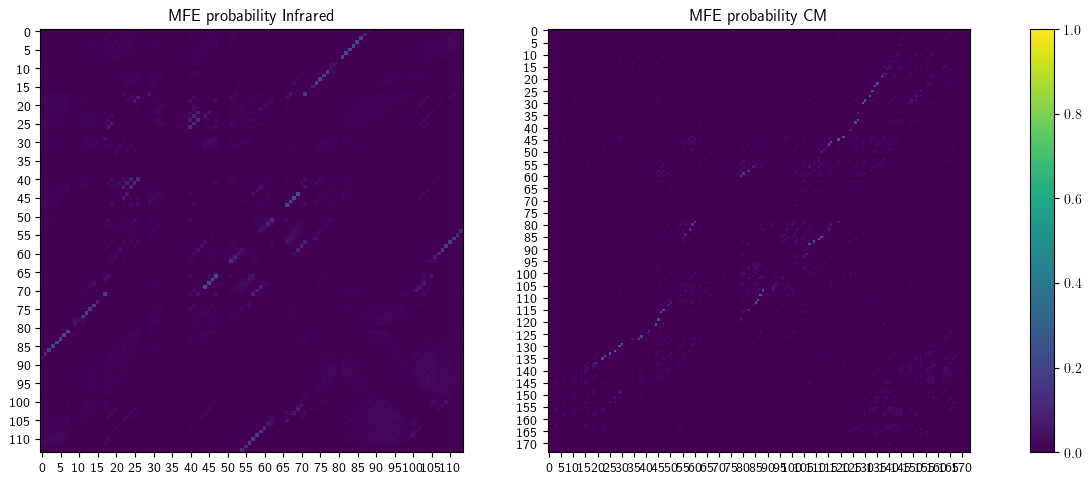

In [ ]:
# get base pairing heatmap of a matrix of base pair probabilities

fig, axes = plt.subplots(1, 2, figsize=(12,9))
img1 = axes[0].imshow(IR_bps, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
axes[0].set_xticks(np.arange(0, IR_bps.shape[1], 5), np.arange(0, IR_bps.shape[1], 5))
axes[0].set_yticks(np.arange(0, IR_bps.shape[0], 5), np.arange(0, IR_bps.shape[0], 5))
axes[0].set_title('MFE probability Infrared')
# axes[0].grid(color='gray', linestyle='--', linewidth=0.4)

img2 = axes[1].imshow(CM_bps, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
axes[1].set_xticks(np.arange(0, CM_bps.shape[1], 5), np.arange(0, CM_bps.shape[1], 5))
axes[1].set_yticks(np.arange(0, CM_bps.shape[0], 5), np.arange(0, CM_bps.shape[0], 5))
axes[1].set_title('MFE probability CM')
# axes[1].grid(color='gray', linestyle='--', linewidth=0.4)
# print([axes[1].get_position().x1-0.25,axes[1].get_position().y0,0.02,axes[0].get_position().y1-axes[1].get_position().y0])
cax = fig.add_axes([0.95, 0.26, 0.02,axes[0].get_position().y1-axes[1].get_position().y0])
fig.colorbar(img1, cax=cax)


save_fig = '/scr/aldea/kgutenbrunner/working/thesis/images/TBFV_design_mfes.png'
plt.savefig(save_fig)
